# Swarms

In Underworld, the swarm is an object that defines a collection of particles. Swarms are usually used to track the Lagrangian quantities required for a given model, such as a material type identifier, or the plastic strain of an advecting parcel of fluid. Swarm may be used passively to record information as they advect, or actively where the values recorded on particles actually feed into rheologies or forces. 

Swarms of particles may:

1. Advect through the mesh according to a user specified velocity.
2. Store arbitrary data on a per-particle basis.
3. Freely cross process boundaries in parallel simulations.

The type of data stored within any given swarm is homogenous across all particles, though naturally the actual values will generally be different from particle to particle.

The user is free to create an arbitrary number of swarms, and each swarm may contain an arbitrary number of particles. Particles may also be added to a swarm at any stage either directly or through population control mechanisms. Particles may also be deleted, though currently this is only possible through indirect means.


#### Overview
1. Creating a swarm object and different layouts.
2. Creating a swarm from a numpy array and modifying positions.
3. Adding swarm particle variables.
4. Case-study, making a circle with particles.
5. Saving and loading swarms.


**Keywords:** swarms, particles, shapes


In [1]:
import underworld as uw
import glucifer
import numpy as np

## Creating a swarm object

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

swarm = uw.swarm.Swarm( mesh=mesh )

#### Create a layout object

Layout objects are used to populate the swarm across the entire domain. Various layout objects are available within the layouts submodule.



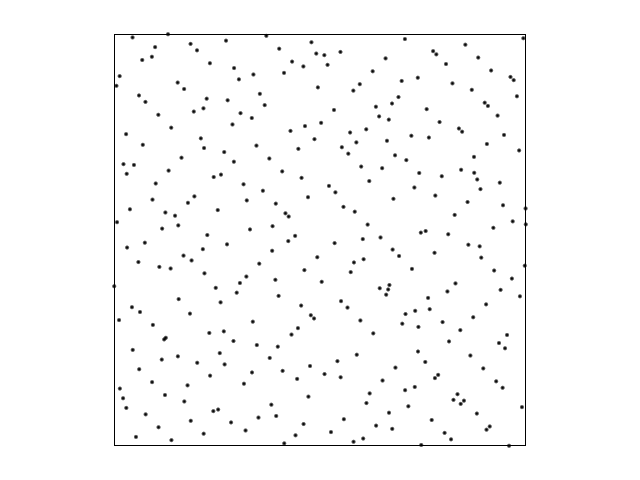

In [3]:
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# perform the populating
swarm.populate_using_layout( layout=swarmLayout )

# visualise the swarm
fig = glucifer.Figure()
fig.append( glucifer.objects.Points(swarm=swarm, pointSize=5, colourBar=False) )
fig.show()


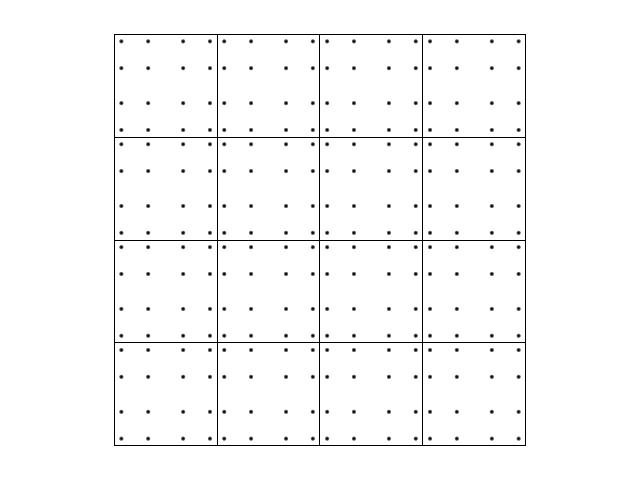

In [4]:
# example of a PerCellGaussLayout
swarm = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=4 )
swarm.populate_using_layout( layout=swarmLayout )

fig = glucifer.Figure()
fig.append( glucifer.objects.Points(swarm=swarm, pointSize=5, colourBar=False) )
fig.append( glucifer.objects.Mesh(mesh) )
fig.show()

## Populating a swarm from numpy array

Swarms can also be populated using numpy arrays that specify particle coordinates. 

In [5]:
# initialise a swarm
swarmCustom = uw.swarm.Swarm( mesh=mesh, particleEscape=True )

# create the array
swarmCoords = np.array([ [0.2,0.2], [0.4,0.4],[0.6,0.6],[0.8,0.8],[1.8,1.8]])

# use the array to add particles at the specified coordinates.
swarmCustom.add_particles_with_coordinates(swarmCoords)

array([ 0,  1,  2,  3, -1], dtype=int32)

Note the array returned above. It specifies the local identifiers for the added particles. Coordinates which are not within the (local) domain will be ignored and are signified with a `-1`. For parallel simulation, the domain is partitioned across all processes, and therefore coordinates which are ignored on one process (ie, no particle created) may be consumed on another process (ie, particle created).




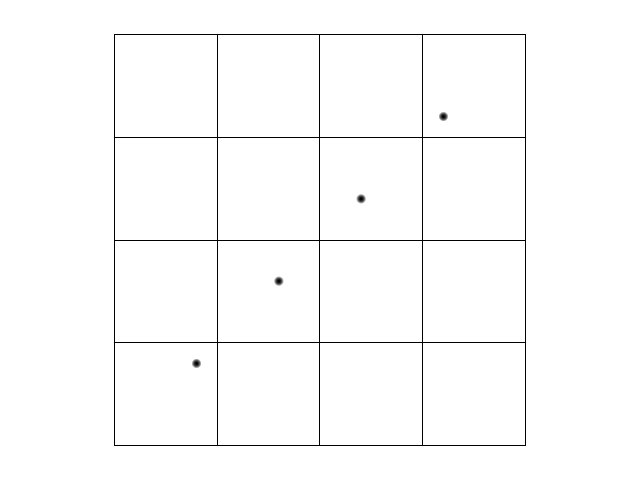

In [6]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Points(swarm=swarmCustom, pointSize=10, colourBar=False) )
fig.append( glucifer.objects.Mesh(mesh))
fig.show()

### Modifying particle positions

Let's move a single particle.

Note that we need to use the `deform_swarm` context manager to modify particle locations. This is necessary because various internal book keeping needs to be occur after a user modifies particle positions.


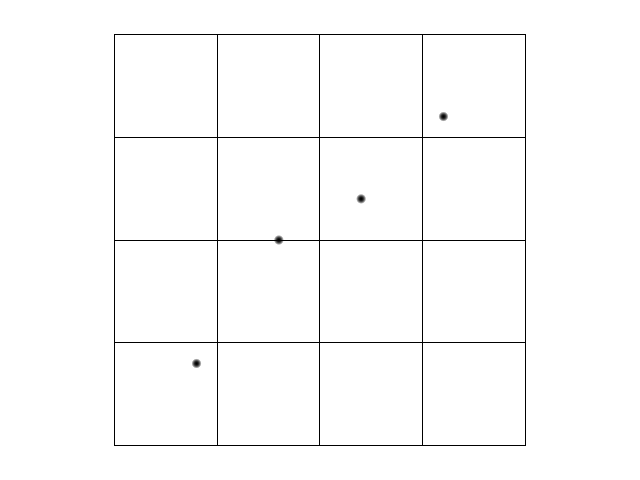

In [7]:
with swarmCustom.deform_swarm():
    swarmCustom.particleCoordinates.data[1] = (0.4,0.5)

# replot
fig.show()

### Delete a particle

Currently the only way to delete a particle is to move it outside the global domain. Note that the swarm object must also be created with `particleEscape=True`.


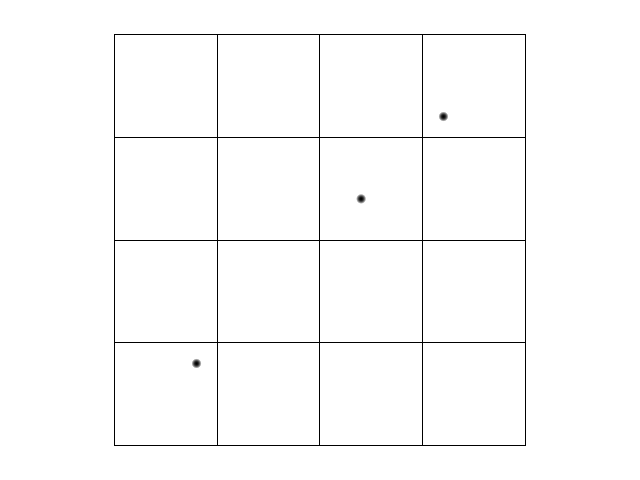

In [8]:
with swarmCustom.deform_swarm():
    swarmCustom.particleCoordinates.data[1] = (9999,9999.)

# replot
fig.show()

## Adding particle variables

Let us add a new variable to the swarm. Each particle will record a value of the given type and count.

In [9]:
swarmVariable = swarmCustom.add_variable(dataType='double', count=1)

In [10]:
swarmVariable.data[0] = 1.
swarmVariable.data[1] = 10.
swarmVariable.data[2] = 100.


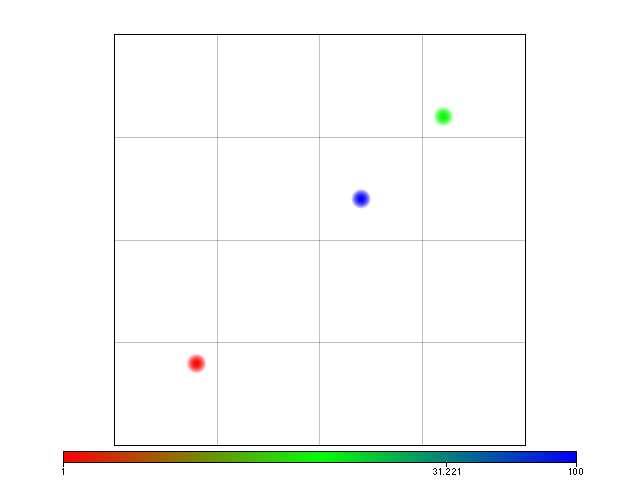

In [11]:
# plot the swarmVariable 

fig = glucifer.Figure()
fig.append( glucifer.objects.Points( swarm=swarmCustom, pointSize=20, 
                                      fn_colour=swarmVariable, colourBar = True,
                                      colours="red green blue", logScale=True) )
fig.append( glucifer.objects.Mesh(mesh, opacity=0.25))
fig.show()

## A case study - making a circle with particles


This example will demonstrate the creation of geometry using swarm variables. Particle geometries often form means to define initial fluid/material distribution in models. 

For more information on how this method can be used to set material parameters to particles see the **StokesSinker** example.

In [12]:
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (64, 64), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) )
swarm = uw.swarm.Swarm( mesh=mesh )

# add a data variable which will store an index to determine material
materialIndex = swarm.add_variable( dataType="int", count=1 )

# populate our swarm across the mesh domain
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )
materialIndex.data[:] = 0 

**Define a circle**

We want our `materialIndex` to define a circle. 

Here we use a python loop to traverse the particles and define the `materialIndex` depending on whether the particle's position is inside the circle or not.

More efficient ways to achieve this are presented in the **Functions** section of the user guide.

In [13]:
# our circles parameters
circleRadius = 0.1
circleCentre = (0.5, 0.5)

# the particle loop
for index, coord in enumerate(swarm.particleCoordinates.data):
    x = coord[0]
    z = coord[1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        materialIndex.data[index] = 1
    else:
        materialIndex.data[index] = 0


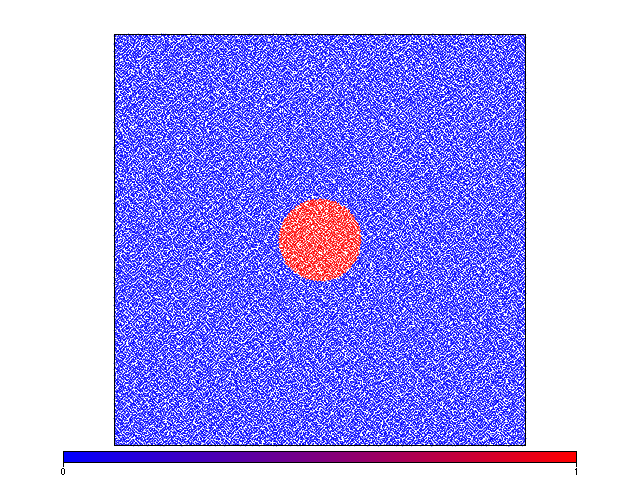

In [14]:
# visualise the swarm
fig = glucifer.Figure()
fig.append( glucifer.objects.Points( swarm=swarm, fn_colour=materialIndex, colours='blue red', 
                               colourBar=True, pointSize=2.0 ) )
fig.show()

## Saving a swarm

As with other data types, the `save()` method is used to save `Swarm` and `SwarmVariable` objects. 

In [15]:
swarm.save("SwarmWithCircle.h5")
materialIndex.save("SwarmWithCircle.materialIndex.h5")

Note that the above methods return `SavedFileData` objects which are used required if you wish to create XDMF files and can be ignored otherwise. See the **Utilities** section of the user guide for further information. 

## Loading a swarm

Similarly, the `load()` method is used to load `Swarm` and `SwarmVariable` objects. Note that it is necessary to load the `Swarm` object before the corresponding `SwarmVariable` object can be loaded. Ie, you cannot load directly onto an existing `SwarmVariable` without first loading a `Swarm`.  This is to ensure that both objects are in a compatible state (specifically, the correct number of particles exists **and** the data ordering is identical).

In [16]:
swarmCopy = uw.swarm.Swarm( mesh=mesh )
swarmCopy.load("SwarmWithCircle.h5")

# The swarm geometry is now loaded but the swarmVariables are not restored.
# We have to explicitly create and re-populate any variables we have previously saved

materialIndexCopy = swarmCopy.add_variable("int",1)
materialIndexCopy.load("SwarmWithCircle.materialIndex.h5")


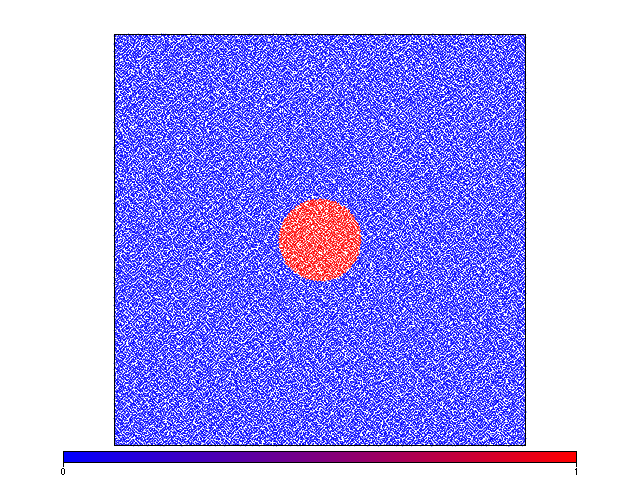

In [17]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Points( swarm=swarmCopy, fn_colour=materialIndexCopy, colours='blue red', 
                                      colourBar=True, pointSize=2.0 ) )
fig.show()

In [18]:
# Cleanup
if uw.rank()==0:
    import os
    os.remove( "SwarmWithCircle.h5" )
    os.remove( "SwarmWithCircle.materialIndex.h5" )